<a href="https://colab.research.google.com/github/yshnxd/solaris2/blob/main/solaris_REINCARNATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Libraries

In [ ]:
# === STEP 0: Setup Libraries ===
# Core
import numpy as np
import pandas as pd
import gc
import os
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Technical indicators & TA-Lib alternative
!pip install ta --quiet
import ta

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
)

# XGBoost
!pip install xgboost --quiet
from xgboost import XGBClassifier, XGBRegressor

# Deep Learning (TensorFlow/Keras)
!pip install tensorflow --quiet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv1D, MaxPooling1D,
    LSTM, Input, BatchNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Utilities for reproducibility
import random
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Libraries loaded successfully.")


  Preparing metadata (setup.py) ... done
✅ Libraries loaded successfully.


# Collect Data

In [ ]:
# === STEP 1: Data Collection (Hourly) ===
!pip install yfinance --quiet
import yfinance as yf
from datetime import datetime
import pandas as pd
import os

# Target + market context tickers
tickers = [
    "AAPL",  # tech megacap, consumer + innovation driver
    "MSFT",  # tech/enterprise backbone
    "AMZN",  # e-commerce + cloud
    "GOOGL", # search/ads + AI
    "TSLA",  # EV + growth volatility
    "NVDA",  # AI + semiconductors
    "JPM",   # finance, leading bank
    "JNJ",   # healthcare/pharma stability
    "XOM",   # energy leader
    "CAT",   # industrials/infrastructure
    "BA",    # aerospace/defense
    "META"   # social + ads volatility
]
interval = "60m"  # 1-hour bars
period = "729d"   # max allowed for hourly

data_dict = {}
print("Downloading hourly data...")
for t in tickers:
    try:
        df = yf.download(t, interval=interval, period=period, progress=False)
        df.dropna(inplace=True)
        df.index = df.index.tz_localize(None)
        data_dict[t] = df
        print(f"{t}: {df.shape[0]} rows from {df.index.min()} to {df.index.max()}")
    except Exception as e:
        print(f"❌ Failed to get {t}: {e}")
# ✅ Replace old close_df creation with this
target_index = data_dict["AAPL"].index
aligned_close = pd.DataFrame(index=target_index)

for t, df in data_dict.items():
    aligned_close[t] = df.reindex(target_index)['Close']

print("\nSample aligned close prices:")
print(aligned_close.tail())

# Save raw hourly data
os.makedirs("data_raw", exist_ok=True)
for t, df in data_dict.items():
    df.to_csv(f"data_raw/{t}_60m.csv")
print("\n✅ Hourly data downloaded and saved to 'data_raw/'")


AAPL: 5075 rows from 2022-10-07 13:30:00 to 2025-09-04 19:30:00
MSFT: 5075 rows from 2022-10-07 13:30:00 to 2025-09-04 19:30:00
AMZN: 5075 rows from 2022-10-07 13:30:00 to 2025-09-04 19:30:00
GOOGL: 5075 rows from 2022-10-07 13:30:00 to 2025-09-04 19:30:00
TSLA: 5075 rows from 2022-10-07 13:30:00 to 2025-09-04 19:30:00
NVDA: 5075 rows from 2022-10-07 13:30:00 to 2025-09-04 19:30:00
JPM: 5075 rows from 2022-10-07 13:30:00 to 2025-09-04 19:30:00
JNJ: 5075 rows from 2022-10-07 13:30:00 to 2025-09-04 19:30:00
XOM: 5075 rows from 2022-10-07 13:30:00 to 2025-09-04 19:30:00
CAT: 5075 rows from 2022-10-07 13:30:00 to 2025-09-04 19:30:00
BA: 5075 rows from 2022-10-07 13:30:00 to 2025-09-04 19:30:00
META: 5075 rows from 2022-10-07 13:30:00 to 2025-09-04 19:30:00

Sample aligned close prices:
                           AAPL        MSFT        AMZN       GOOGL  \
Datetime                                                              
2025-09-04 15:30:00  237.160004  506.000000  233.514999  228.1049

#Feature Creation

Creating Features

In [ ]:
all_feat_data = []

# Forward-fill aligned_close once globally
aligned_ffill = aligned_close.ffill()

for ticker in aligned_ffill.columns:
    # Skip if all values are NaN
    if aligned_ffill[ticker].isna().all():
        continue

    price_series = aligned_ffill[ticker]
    feat_tmp = pd.DataFrame(index=price_series.index)

    # Lag returns
    for lag in [1, 3, 6, 12, 24]:
        feat_tmp[f"ret_{lag}h"] = price_series.pct_change(lag)

    # Rolling volatility
    for window in [6, 12, 24]:
        feat_tmp[f"vol_{window}h"] = price_series.pct_change().rolling(window).std()

    # Technical indicators
    try:
        feat_tmp["rsi_14"] = ta.momentum.RSIIndicator(price_series, window=14).rsi()
    except Exception:
        feat_tmp["rsi_14"] = np.nan
    try:
        macd = ta.trend.MACD(price_series)
        feat_tmp["macd"] = macd.macd()
        feat_tmp["macd_signal"] = macd.macd_signal()
    except Exception:
        feat_tmp["macd"] = np.nan
        feat_tmp["macd_signal"] = np.nan

    # Moving averages
    for w in [5, 10, 20]:
        feat_tmp[f"sma_{w}"] = price_series.rolling(w).mean()
        feat_tmp[f"ema_{w}"] = price_series.ewm(span=w, adjust=False).mean()

    # Volume features
    if ticker in data_dict and "Volume" in data_dict[ticker].columns:
        vol_series = data_dict[ticker].reindex(price_series.index)["Volume"].ffill()
        feat_tmp["vol_change_1h"] = vol_series.pct_change()
        feat_tmp["vol_ma_24h"] = vol_series.rolling(24).mean()

    # Cross-asset returns — from the globally ffilled dataframe
    for asset in ["AAPL",  # tech megacap, consumer + innovation driver
    "MSFT",  # tech/enterprise backbone
    "AMZN",  # e-commerce + cloud
    "GOOGL", # search/ads + AI
    "TSLA",  # EV + growth volatility
    "NVDA",  # AI + semiconductors
    "JPM",   # finance, leading bank
    "JNJ",   # healthcare/pharma stability
    "XOM",   # energy leader
    "CAT",   # industrials/infrastructure
    "BA",    # aerospace/defense
    "META"]:

      if asset in aligned_ffill.columns:
            feat_tmp[f"{asset}_ret_1h"] = aligned_ffill[asset].pct_change()

    # Calendar features
    feat_tmp["hour"] = feat_tmp.index.hour
    feat_tmp["day_of_week"] = feat_tmp.index.dayofweek

    # Only drop rows with NaNs in features for THIS ticker
    drop_cols = [col for col in feat_tmp.columns if col not in ["datetime", "ticker"]]
    feat_tmp = feat_tmp.dropna(subset=drop_cols)

    feat_tmp["datetime"] = feat_tmp.index
    feat_tmp["ticker"] = ticker

    all_feat_data.append(feat_tmp.reset_index(drop=True))

features_df = pd.concat(all_feat_data, ignore_index=True)

print(f"✅ Created features for {features_df['ticker'].nunique()} tickers")
print("Shape:", features_df.shape)
print(features_df.head())

✅ Created features for 12 tickers
Shape: (60504, 35)
     ret_1h    ret_3h    ret_6h   ret_12h   ret_24h    vol_6h   vol_12h  \
0  0.010567  0.015609  0.030296  0.020154  0.019625  0.015878  0.011380   
1  0.002948  0.008539  0.052511  0.023124  0.021150  0.011376  0.011372   
2 -0.015884 -0.002553  0.006797  0.010635 -0.001916  0.010074  0.012419   
3 -0.001849 -0.014808  0.000570  0.009166 -0.004856  0.009999  0.012440   
4 -0.006624 -0.024210 -0.015878  0.001653 -0.006412  0.008976  0.012625   

    vol_24h     rsi_14      macd  ...  JPM_ret_1h  JNJ_ret_1h  XOM_ret_1h  \
0  0.008904  61.414631  0.170813  ...    0.006073   -0.000848    0.001032   
1  0.008914  62.828078  0.379671  ...   -0.000274    0.001030    0.000540   
2  0.009447  51.786366  0.357898  ...    0.014456   -0.004782   -0.019971   
3  0.009451  50.687597  0.316019  ...    0.022592    0.001521    0.006659   
4  0.009491  46.858170  0.205427  ...   -0.010980   -0.002429   -0.004178   

   CAT_ret_1h  BA_ret_1h  META_re

Label Creation

In [ ]:
# === LABEL CREATION FOR ALL TICKERS (pooled dataset, regression version) ===

horizon = 1               # predict 1 hour ahead

all_data = []

for ticker in aligned_close.columns:
    # Skip if ticker is all NaN (e.g., ^VIX alignment issues)
    if aligned_close[ticker].dropna().empty:
        continue

    price_series = aligned_close[ticker]

    # Forward return (future percentage change)
    future_price = price_series.shift(-horizon)
    future_ret = (future_price - price_series) / price_series

    # Drop NaNs (where future_ret is nan)
    valid_idx = future_ret.dropna().index

    # Combine into dataframe
    df_tmp = pd.DataFrame({
        "datetime": valid_idx,
        "ticker": ticker,
        "price": price_series.loc[valid_idx],
        "target": future_ret.loc[valid_idx],  # regression target
    })

    all_data.append(df_tmp)

# Combine all tickers
labels_df = pd.concat(all_data, ignore_index=True)

print("Combined dataset shape:", labels_df.shape)
labels_df.head(10)

Combined dataset shape: (60888, 4)


,datetime,ticker,price,target
0,2022-10-07 13:30:00,AAPL,141.119995,0.000779
1,2022-10-07 14:30:00,AAPL,141.229996,-0.003930
2,2022-10-07 15:30:00,AAPL,140.675003,-0.002808
3,2022-10-07 16:30:00,AAPL,140.279999,-0.001441
4,2022-10-07 17:30:00,AAPL,140.077896,-0.002541
5,2022-10-07 18:30:00,AAPL,139.721893,0.002563
6,2022-10-07 19:30:00,AAPL,140.080002,-0.000214
7,2022-10-10 13:30:00,AAPL,140.050003,-0.000214
8,2022-10-10 14:30:00,AAPL,140.020004,-0.001946
9,2022-10-10 15:30:00,AAPL,139.747498,0.001449


Scaling

# Preprocessing

Normalize Features

In [ ]:
# Merge features with labels
df = features_df.merge(labels_df, on=["datetime", "ticker"], how="inner")

# Drop NaNs (just in case)
df = df.dropna()

# Separate features & target
X = df.drop(columns=["datetime", "ticker", "target"])
y = df["target"]

print("X shape:", X.shape)
print("y stats:\n", y.describe())

X shape: (60492, 34)
y stats:
 count    60492.000000
mean         0.000206
std          0.008491
min         -0.216320
25%         -0.002552
50%          0.000188
75%          0.002891
max          0.255918
Name: target, dtype: float64


Scale

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Merge features and labels
df = features_df.merge(labels_df, on=["datetime", "ticker"], how="inner")

# Sort by time
df = df.sort_values(["datetime", "ticker"]).reset_index(drop=True)

# Replace inf values with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaNs
df = df.dropna()

# Separate features & target
X = df.drop(columns=["datetime", "ticker", "target"])
y = df["target"]

# Time-based split
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val = X.iloc[train_size:train_size + val_size]
y_val = y.iloc[train_size:train_size + val_size]

X_test = X.iloc[train_size + val_size:]
y_test = y.iloc[train_size + val_size:]

# Ensure all values are finite before scaling
assert np.isfinite(X_train.values).all(), "Found non-finite values in X_train!"

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"✅ Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("Target stats in Train:\n", y_train.describe())

✅ Train: (42331, 34), Val: (9071, 34), Test: (9072, 34)
Target stats in Train:
 count    42331.000000
mean         0.000218
std          0.008276
min         -0.216320
25%         -0.002550
50%          0.000202
75%          0.002892
max          0.255918
Name: target, dtype: float64


Sequence making - For LSTM AND CNN

In [ ]:
import numpy as np

def create_sequences(X, y, seq_len=24):
    """
    Convert tabular (samples, features) into sequential (samples, seq_len, features)
    for CNN/LSTM, keeping labels aligned to the last timestep.
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])  # label at next hour
    return np.array(X_seq), np.array(y_seq)

# === Choose sequence length ===
SEQ_LEN = 128

# Reshape train/val/test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train.values, SEQ_LEN)
X_val_seq,   y_val_seq   = create_sequences(X_val,   y_val.values,   SEQ_LEN)
X_test_seq,  y_test_seq  = create_sequences(X_test,  y_test.values,  SEQ_LEN)

print(f"Train seq: {X_train_seq.shape}, Val seq: {X_val_seq.shape}, Test seq: {X_test_seq.shape}")


Train seq: (42203, 128, 34), Val seq: (8943, 128, 34), Test seq: (8944, 128, 34)


In [ ]:
import numpy as np

# If your y_* are numpy arrays (sequence targets), you don't need to encode them for regression
# Just ensure they are np.float32 (or np.float64) and have the right shape for your model

# Example: conversion to float and correct shape for Keras (if needed)
y_train_seq_float = np.asarray(y_train_seq, dtype=np.float32)
y_val_seq_float   = np.asarray(y_val_seq, dtype=np.float32)
y_test_seq_float  = np.asarray(y_test_seq, dtype=np.float32)

print("Train target stats:",
      f"mean={np.mean(y_train_seq_float):.4f}, std={np.std(y_train_seq_float):.4f}, min={np.min(y_train_seq_float):.4f}, max={np.max(y_train_seq_float):.4f}")

Train target stats: mean=0.0002, std=0.0083, min=-0.2163, max=0.2559


# Build the Model

CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import metrics as keras_metrics

# Model hyperparameters
SEQUENCE_LENGTH = 128  # past 128 hours
NUM_FEATURES = 34      # per hour

def cnnmodel(seq_len=SEQUENCE_LENGTH, num_features=NUM_FEATURES):
    inputs = layers.Input(shape=(seq_len, num_features))  # (128, 51)

    # First 1D Conv block
    x = layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.2)(x)

    # Second 1D Conv block
    x = layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.2)(x)

    # Third 1D Conv block
    x = layers.Conv1D(filters=256, kernel_size=7, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)

    # Global pooling for sequence dimension
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers for regression
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Output layer (regression: predict next-hour return/price)
    outputs = layers.Dense(1, activation='linear')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile model for regression
    model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="mse",
    metrics=[
        keras_metrics.MeanAbsoluteError(name="mae"),
        keras_metrics.RootMeanSquaredError(name="rmse")
    ])

    return model

# Build and print summary
cnn_model = cnnmodel()
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 34)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 64)        │         6,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 256)        │       229,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,089 (1.22 MB)

 Trainable params: 319,809 (1.22 MB)

 Non-trainable params: 1,280 (5.00 KB)

LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import metrics as keras_metrics

# Model hyperparameters
SEQUENCE_LENGTH = 128  # past 128 hours
NUM_FEATURES = 34      # per hour

def lstmmodel(seq_len=SEQUENCE_LENGTH, num_features=NUM_FEATURES):
    inputs = layers.Input(shape=(seq_len, num_features))

    # LSTM block 1
    x = layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
    x = layers.LayerNormalization()(x)   # ✅ LayerNorm stabilizes sequence learning
    x = layers.Dropout(0.3)(x)

    # LSTM block 2
    x = layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(x)
    x = layers.LayerNormalization()(x)   # ✅ use LayerNorm instead of BatchNorm
    x = layers.Dropout(0.3)(x)

    # Dense layers for regression
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)   # ✅ BatchNorm is fine here (non-sequence MLP)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Output layer (regression: predict next-hour price/return)
    outputs = layers.Dense(1, activation='linear')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="mse",
    metrics=[
        keras_metrics.MeanAbsoluteError(name="mae"),
        keras_metrics.RootMeanSquaredError(name="rmse")
    ])
    return model

# Build and print summary
lstm_model = lstmmodel()
lstm_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 34)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128, 128)       │        83,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 128, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,905 (546.50 KB)

 Trainable params: 139,713 (545.75 KB)

 Non-trainable params: 192 (768.00 B)

XGBOOST

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---- y_train, y_val, y_test are already regression targets (floats) ----
# If y_train etc are lists, convert to numpy arrays for XGBoost
y_train_tab = np.asarray(y_train, dtype=np.float32)
y_val_tab = np.asarray(y_val, dtype=np.float32)
y_test_tab = np.asarray(y_test, dtype=np.float32)

# ---- XGBoost regressor ----
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',   # regression objective
    n_estimators=1000,              # set high + use early stopping
    learning_rate=0.03,
    max_depth=6,
    min_child_weight=3,
    gamma=1,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',             # 'gpu_hist' if you have GPU
    eval_metric='rmse'
)

# Example fit (add early stopping if desired):
# xgb_reg.fit(X_train, y_train_tab, eval_set=[(X_val, y_val_tab)], early_stopping_rounds=25, verbose=True)

# Example prediction:
# y_pred = xgb_reg.predict(X_test)
# print("Test MSE:", mean_squared_error(y_test_tab, y_pred))
# print("Test MAE:", mean_absolute_error(y_test_tab, y_pred))
# print("Test R2:", r2_score(y_test_tab, y_pred))

# Train the model

CNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TerminateOnNaN


# ---- Define metrics explicitly (avoid 'rmse' string) ----
metrics = [
    tf.keras.metrics.MeanAbsoluteError(name="mae"),
    tf.keras.metrics.RootMeanSquaredError(name="rmse"),
]

# ---- Callbacks ----
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

model_ckpt = ModelCheckpoint(
    filepath="best_cnn.weights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

kill_on_nan = TerminateOnNaN()

callbacks = [early_stop, reduce_lr, model_ckpt, kill_on_nan]

# ---- Train ----
history = cnn_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=2
)

# ---- Load best weights & evaluate ----
cnn_model.load_weights("best_cnn.weights.h5")

train_eval = cnn_model.evaluate(X_train_seq, y_train_seq, verbose=0)
val_eval   = cnn_model.evaluate(X_val_seq,   y_val_seq,   verbose=0)

print("Final Training Metrics:")
print(f"Loss (MSE): {train_eval[0]:.6f} | MAE: {train_eval[1]:.6f} | RMSE: {train_eval[2]:.6f}")

print("Final Validation Metrics:")
print(f"Loss (MSE): {val_eval[0]:.6f} | MAE: {val_eval[1]:.6f} | RMSE: {val_eval[2]:.6f}")


Epoch 1/100

Epoch 1: val_loss improved from inf to 0.00208, saving model to best_cnn.weights.h5
660/660 - 170s - 257ms/step - loss: 0.2874 - mae: 0.3417 - rmse: 0.5361 - val_loss: 0.0021 - val_mae: 0.0354 - val_rmse: 0.0457 - learning_rate: 1.0000e-03
Epoch 2/100

Epoch 2: val_loss improved from 0.00208 to 0.00021, saving model to best_cnn.weights.h5
660/660 - 151s - 228ms/step - loss: 0.0098 - mae: 0.0560 - rmse: 0.0991 - val_loss: 2.1492e-04 - val_mae: 0.0108 - val_rmse: 0.0147 - learning_rate: 1.0000e-03
Epoch 3/100

Epoch 3: val_loss improved from 0.00021 to 0.00008, saving model to best_cnn.weights.h5
660/660 - 202s - 307ms/step - loss: 2.3600e-04 - mae: 0.0087 - rmse: 0.0154 - val_loss: 7.9445e-05 - val_mae: 0.0051 - val_rmse: 0.0089 - learning_rate: 1.0000e-03
Epoch 4/100

Epoch 4: val_loss did not improve from 0.00008
660/660 - 152s - 231ms/step - loss: 6.9938e-05 - mae: 0.0048 - rmse: 0.0084 - val_loss: 7.9865e-05 - val_mae: 0.0051 - val_rmse: 0.0089 - learning_rate: 1.0000e-

LSTM

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TerminateOnNaN

# ---- Define metrics explicitly for regression ----
metrics = [
    tf.keras.metrics.MeanAbsoluteError(name="mae"),
    tf.keras.metrics.RootMeanSquaredError(name="rmse"),
]

# ---- Callbacks ----
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

model_ckpt = ModelCheckpoint(
    filepath="best_lstm.weights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

kill_on_nan = TerminateOnNaN()

callbacks = [early_stop, reduce_lr, model_ckpt, kill_on_nan]

# ---- Train ----
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=2
)

# ---- Load best weights & evaluate ----
lstm_model.load_weights("best_lstm.weights.h5")

train_eval = lstm_model.evaluate(X_train_seq, y_train_seq, verbose=0)
val_eval   = lstm_model.evaluate(X_val_seq,   y_val_seq,   verbose=0)

print("Final Training Metrics:")
print(f"Loss (MSE): {train_eval[0]:.6f} | MAE: {train_eval[1]:.6f} | RMSE: {train_eval[2]:.6f}")

print("Final Validation Metrics:")
print(f"Loss (MSE): {val_eval[0]:.6f} | MAE: {val_eval[1]:.6f} | RMSE: {val_eval[2]:.6f}")

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.00090, saving model to best_lstm.weights.h5
660/660 - 347s - 525ms/step - loss: 0.1907 - mae: 0.2929 - rmse: 0.4367 - val_loss: 8.9615e-04 - val_mae: 0.0225 - val_rmse: 0.0299 - learning_rate: 1.0000e-03
Epoch 2/100

Epoch 2: val_loss improved from 0.00090 to 0.00011, saving model to best_lstm.weights.h5
660/660 - 378s - 572ms/step - loss: 0.0064 - mae: 0.0555 - rmse: 0.0799 - val_loss: 1.0769e-04 - val_mae: 0.0069 - val_rmse: 0.0104 - learning_rate: 1.0000e-03
Epoch 3/100

Epoch 3: val_loss improved from 0.00011 to 0.00008, saving model to best_lstm.weights.h5
660/660 - 321s - 487ms/step - loss: 2.5675e-04 - mae: 0.0109 - rmse: 0.0160 - val_loss: 8.0230e-05 - val_mae: 0.0051 - val_rmse: 0.0090 - learning_rate: 1.0000e-03
Epoch 4/100

Epoch 4: val_loss improved from 0.00008 to 0.00008, saving model to best_lstm.weights.h5
660/660 - 343s - 519ms/step - loss: 7.0686e-05 - mae: 0.0049 - rmse: 0.0084 - val_loss: 7.9666e-05 - val_mae: 0.

XGBOOST

In [14]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---- y_train, y_val, y_test are already regression targets (floats) ----
y_train_tab = np.asarray(y_train, dtype=np.float32)
y_val_tab = np.asarray(y_val, dtype=np.float32)
y_test_tab = np.asarray(y_test, dtype=np.float32)

# ---- XGBoost regressor ----
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,              # high value; use early stopping
    learning_rate=0.03,
    max_depth=6,
    min_child_weight=3,
    gamma=1,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',             # 'gpu_hist' if you have GPU
    eval_metric='rmse'
)

# ---- Train with early stopping ----
xgb_reg.fit(
    X_train, y_train_tab,
    eval_set=[(X_val, y_val_tab)],
    verbose=True
)

# ---- Evaluate on train/validation/test ----
print("\nEvaluation on Train:")
y_pred_train = xgb_reg.predict(X_train)
print("MSE:", mean_squared_error(y_train_tab, y_pred_train))
print("MAE:", mean_absolute_error(y_train_tab, y_pred_train))
print("R2:", r2_score(y_train_tab, y_pred_train))

print("\nEvaluation on Validation:")
y_pred_val = xgb_reg.predict(X_val)
print("MSE:", mean_squared_error(y_val_tab, y_pred_val))
print("MAE:", mean_absolute_error(y_val_tab, y_pred_val))
print("R2:", r2_score(y_val_tab, y_pred_val))

print("\nEvaluation on Test:")
y_pred_test = xgb_reg.predict(X_test)
print("MSE:", mean_squared_error(y_test_tab, y_pred_test))
print("MAE:", mean_absolute_error(y_test_tab, y_pred_test))
print("R2:", r2_score(y_test_tab, y_pred_test))

[0]	validation_0-rmse:0.00884
[1]	validation_0-rmse:0.00884
[2]	validation_0-rmse:0.00884
[3]	validation_0-rmse:0.00884
[4]	validation_0-rmse:0.00884
[5]	validation_0-rmse:0.00884
[6]	validation_0-rmse:0.00884
[7]	validation_0-rmse:0.00884
[8]	validation_0-rmse:0.00884
[9]	validation_0-rmse:0.00884
[10]	validation_0-rmse:0.00884
[11]	validation_0-rmse:0.00884
[12]	validation_0-rmse:0.00884
[13]	validation_0-rmse:0.00884
[14]	validation_0-rmse:0.00884
[15]	validation_0-rmse:0.00884
[16]	validation_0-rmse:0.00884
[17]	validation_0-rmse:0.00884
[18]	validation_0-rmse:0.00884
[19]	validation_0-rmse:0.00884
[20]	validation_0-rmse:0.00884
[21]	validation_0-rmse:0.00884
[22]	validation_0-rmse:0.00884
[23]	validation_0-rmse:0.00884
[24]	validation_0-rmse:0.00884
[25]	validation_0-rmse:0.00884
[26]	validation_0-rmse:0.00884
[27]	validation_0-rmse:0.00884
[28]	validation_0-rmse:0.00884
[29]	validation_0-rmse:0.00884
[30]	validation_0-rmse:0.00884
[31]	validation_0-rmse:0.00884
[32]	validation_0-

# O-O-F Predictions

In [15]:
# Use correct aligned length (should match X_train_seq or X_tab_aligned)
n_samples = X_train_seq.shape[0]  # or X_tab_aligned.shape[0], should be 17607
oof_cnn = np.zeros((n_samples, 3))
oof_lstm = np.zeros((n_samples, 3))
oof_xgb = np.zeros((n_samples, 3))

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

# ==== Combine your split data back into one dataset ====
X_tab = np.vstack([X_train, X_val, X_test])
y_tab = np.concatenate([y_train, y_val, y_test])

# ==== Time series split config ====
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# ==== Align all arrays to the same length ====
min_len = min(len(X_tab), len(X_train_seq), len(y_tab))

X_tab_aligned = X_tab[:min_len]
X_train_seq_aligned = X_train_seq[:min_len]
y_tab_aligned = y_tab[:min_len]  # shape (min_len,)
# If you need shape (min_len, 1) for DL models:
# y_tab_aligned = y_tab_aligned.reshape(-1, 1)

print(f"Aligned lengths: tab={X_tab_aligned.shape}, seq={X_train_seq_aligned.shape}, y={y_tab_aligned.shape}")

Aligned lengths: tab=(42203, 34), seq=(42203, 128, 34), y=(42203,)


In [17]:
print("=== Generating CNN OOF predictions ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tab_aligned), 1):
    print(f"\n--- Fold {fold}/{n_splits} ---")
    # Sequences
    X_seq_tr, X_seq_va = X_train_seq_aligned[train_idx], X_train_seq_aligned[val_idx]
    y_seq_tr, y_seq_va = y_tab_aligned[train_idx], y_tab_aligned[val_idx]  # use continuous targets

    # Build + compile
    cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # use regression loss

    # Train
    cnn_model.fit(X_seq_tr, y_seq_tr, validation_data=(X_seq_va, y_seq_va),
                  epochs=5, batch_size=64, verbose=0)
    # Predict
    oof_cnn[val_idx] = cnn_model.predict(X_seq_va, verbose=0)

=== Generating CNN OOF predictions ===

--- Fold 1/3 ---

--- Fold 2/3 ---

--- Fold 3/3 ---


In [18]:
print("=== Generating LSTM OOF predictions ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tab_aligned), 1):
    print(f"\n--- Fold {fold}/{n_splits} ---")
    # Sequences
    X_seq_tr, X_seq_va = X_train_seq_aligned[train_idx], X_train_seq_aligned[val_idx]
    y_seq_tr, y_seq_va = y_tab_aligned[train_idx], y_tab_aligned[val_idx]
    # Build + compile (make sure output units=1 for regression)
    lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    # Train
    lstm_model.fit(X_seq_tr, y_seq_tr, validation_data=(X_seq_va, y_seq_va),
                   epochs=5, batch_size=64, verbose=0)
    # Predict
    oof_lstm[val_idx] = lstm_model.predict(X_seq_va, verbose=0)

=== Generating LSTM OOF predictions ===

--- Fold 1/3 ---

--- Fold 2/3 ---

--- Fold 3/3 ---


In [19]:
import xgboost as xgb

# Initialize OOF array (1D, for regression)
oof_xgb = np.zeros(X_tab_aligned.shape[0])  # shape (N,)

xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,              # high value; use early stopping
    learning_rate=0.03,
    max_depth=6,
    min_child_weight=3,
    gamma=1,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',             # 'gpu_hist' if you have GPU
    eval_metric='rmse'
)

print("=== Generating XGB OOF predictions ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tab_aligned), 1):
    print(f"\n--- Fold {fold}/{n_splits} ---")
    # Tabular split
    X_tr_tab, X_va_tab = X_tab_aligned[train_idx], X_tab_aligned[val_idx]
    y_tr_tab, y_va_tab = y_tab_aligned[train_idx], y_tab_aligned[val_idx]
    # Train
    xgb_reg.fit(X_tr_tab, y_tr_tab,
                eval_set=[(X_va_tab, y_va_tab)],
                verbose=False)
    # Predict (continuous output)
    oof_xgb[val_idx] = xgb_reg.predict(X_va_tab)

# After all OOF prediction cells (CNN, LSTM, XGB)
oof_idx_xgb = np.concatenate([val_idx for _, val_idx in tscv.split(X_tab_aligned)])
print("oof_idx_xgb shape:", oof_idx_xgb.shape)

=== Generating XGB OOF predictions ===

--- Fold 1/3 ---

--- Fold 2/3 ---

--- Fold 3/3 ---
oof_idx_xgb shape: (31650,)


In [20]:
import joblib

joblib.dump(
    {
        "oof_cnn": oof_cnn,
        "oof_lstm": oof_lstm,
        "oof_xgb": oof_xgb,
        "y": y_tab_aligned  # continuous targets for regression
    },
    "oof_preds.pkl"
)
print("💾 OOF predictions saved to oof_preds.pkl")

💾 OOF predictions saved to oof_preds.pkl


In [21]:
idx = np.asarray(oof_idx_xgb)  # shape (17607,)
oof_cnn_aligned = np.asarray(oof_cnn)[idx]
oof_lstm_aligned = np.asarray(oof_lstm)[idx]
oof_xgb_aligned = np.asarray(oof_xgb)[idx]
print("Aligned shapes:", oof_cnn_aligned.shape, oof_lstm_aligned.shape, oof_xgb_aligned.shape)

Aligned shapes: (31650, 3) (31650, 3) (31650,)


# META LEARNER

In [22]:
import numpy as np

# 1) Ensure the XGB index mapping exists
if 'oof_idx_xgb' not in globals():
    raise RuntimeError("oof_idx_xgb not found. Re-run XGB OOF generation to set oof_idx_xgb.")

idx = np.asarray(oof_idx_xgb)

# 2) Select aligned rows from CNN/LSTM/XGB using that mapping
aligned_cnn = np.asarray(oof_cnn)[idx]   # shape (N_aligned,)
aligned_lstm = np.asarray(oof_lstm)[idx] # shape (N_aligned,)
aligned_xgb = np.asarray(oof_xgb)[idx]   # shape (N_aligned,)

# 3) Sanity checks
assert aligned_cnn.shape[0] == aligned_lstm.shape[0] == aligned_xgb.shape[0], \
       f"Aligned shapes mismatch: cnn {aligned_cnn.shape} lstm {aligned_lstm.shape} xgb {aligned_xgb.shape}"

# 4) Build meta matrices (stacked predictions)
meta_X_train = np.column_stack([aligned_cnn, aligned_lstm, aligned_xgb])  # shape: (N_aligned, 3)

# Use the y that matches the aligned samples
if 'y_tab_aligned' in globals():
    meta_y_train = np.asarray(y_tab_aligned)[idx]
elif 'y_tab' in globals():
    meta_y_train = np.asarray(y_tab)[idx]
else:
    raise RuntimeError("No continuous target found for regression meta learner.")

print("meta_X_train shape:", meta_X_train.shape)
print("meta_y_train shape:", meta_y_train.shape)

meta_X_train shape: (31650, 7)
meta_y_train shape: (31650,)


In [23]:
import numpy as np
import pandas as pd

# Stack base model predictions as features (shape: n_samples, 3)
meta_preds = np.column_stack([oof_cnn, oof_lstm, oof_xgb])  # shape (n, 3)

# Compute engineered meta-features derived from base model predictions:
# - per-sample mean, std, max, min across base model predictions
def meta_stats_from_preds(preds_block):
    # preds_block shape (n_samples, n_models)
    mean_pred = preds_block.mean(axis=1)
    std_pred = preds_block.std(axis=1)
    max_pred = preds_block.max(axis=1)
    min_pred = preds_block.min(axis=1)
    stats = np.vstack([mean_pred, std_pred, max_pred, min_pred]).T
    stats_cols = ["mean_pred", "std_pred", "max_pred", "min_pred"]
    return stats, stats_cols

stats, stats_cols = meta_stats_from_preds(meta_preds)

# Optionally add simple original features if available (e.g. last-hour vol, last return).
# If you saved a features/labels DataFrame earlier, load and align here:
# features_df = pd.read_parquet("features_aligned.parquet")  # or load whatever you have
# extra_feats = features_df.loc[:n-1, ["vol_24h", "ret_1h"]].to_numpy()

# Build final meta_X from predictions + stats
meta_X = np.hstack([meta_preds, stats])
meta_feature_names = (
    [f"cnn_pred", "lstm_pred", "xgb_pred"] +
    stats_cols
)

print("Meta X shape:", meta_X.shape)
print("Feature names:", meta_feature_names)

Meta X shape: (42203, 11)
Feature names: ['cnn_pred', 'lstm_pred', 'xgb_pred', 'mean_pred', 'std_pred', 'max_pred', 'min_pred']


In [24]:
from sklearn.ensemble import HistGradientBoostingRegressor
import joblib
import numpy as np

# Use aligned meta arrays produced earlier
if 'meta_X_train' in globals() and 'meta_y_train' in globals():
    X_meta = np.asarray(meta_X_train)
    y_meta = np.asarray(meta_y_train)
else:
    raise RuntimeError("Aligned meta arrays not found. Make sure meta_X_train and meta_y_train exist.")

print("Shapes before fit: X_meta:", X_meta.shape, "y_meta:", y_meta.shape)

# sanity
if X_meta.shape[0] != y_meta.shape[0]:
    raise ValueError(f"Shape mismatch: X_meta rows {X_meta.shape[0]} != y_meta {y_meta.shape[0]}")

# build final model with the best hyperparameters found earlier (best_cfg)
try:
    best_cfg  # noqa: F821
except NameError:
    # fallback: use the best config you printed: {'max_iter':200,'learning_rate':0.1,'max_depth':4}
    best_cfg = {'max_iter': 200, 'learning_rate': 0.1, 'max_depth': 4}

final_model = HistGradientBoostingRegressor(**best_cfg, early_stopping=True, random_state=42)
final_model.fit(X_meta, y_meta)

# Save the trained meta model
joblib.dump(final_model, "meta_learner.pkl")
print("Final meta_learner model trained and saved to meta_learner.pkl")

# Quick train-set diagnostics (regression metrics)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
pred_train = final_model.predict(X_meta)
print("Train RMSE:", np.sqrt(mean_squared_error(y_meta, pred_train)))
print("Train MAE:", mean_absolute_error(y_meta, pred_train))
print("Train R2 Score:", r2_score(y_meta, pred_train))

Shapes before fit: X_meta: (31650, 7) y_meta: (31650,)
Final meta_learner model trained and saved to meta_learner.pkl
Train RMSE: 0.007535525139827724
Train MAE: 0.004260377820287832
Train R2 Score: 0.027402236164692173


In [25]:
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from typing import Optional

def load_and_predict_regression(
    model_path: str,
    meta_X: np.ndarray,
    y: Optional[np.ndarray] = None,
    verbose: bool = True
):
    """
    Loads a saved regression meta model,
    restricts meta_X to the first 7 features if needed,
    predicts continuous values, and returns (preds).
    """
    assert isinstance(meta_X, np.ndarray), "meta_X must be a numpy array"

    # --- force only relevant features, e.g., 7 (3 base + 4 stats) ---
    if meta_X.shape[1] > 7:
        if verbose:
            print(f"[INFO] meta_X has {meta_X.shape[1]} features, truncating to first 7.")
        meta_X = meta_X[:, :7]
    elif meta_X.shape[1] < 3:
        raise ValueError(f"meta_X has {meta_X.shape[1]} features, but at least 3 (base models) are required.")

    # Accept both 'meta_learner.pkl' and 'meta_model.pkl'
    try:
        obj = joblib.load(model_path)
    except FileNotFoundError as e:
        if model_path == "meta_model.pkl":
            print("[WARN] meta_model.pkl not found, trying meta_learner.pkl instead.")
            obj = joblib.load("meta_learner.pkl")
        else:
            raise

    # Expect a fitted regressor
    if isinstance(obj, dict):
        if verbose:
            print("Loaded dict artifact with keys:", list(obj.keys()))
        meta_model = obj.get("meta_model") or obj.get("model") or obj.get("estimator")
    else:
        if verbose:
            print("Loaded estimator directly from", model_path)
        meta_model = obj

    if meta_model is None:
        raise RuntimeError("No 'meta_model' found in artifact and artifact is not a direct estimator.")

    # Get predictions
    preds = meta_model.predict(meta_X)

    # Diagnostics
    if y is not None:
        if len(y) != len(preds):
            raise ValueError(f"Length mismatch: y ({len(y)}) vs preds ({len(preds)})")
        rmse = np.sqrt(mean_squared_error(y, preds))
        mae = mean_absolute_error(y, preds)
        r2 = r2_score(y, preds)
        if verbose:
            print(f"RMSE: {rmse:.4f}   MAE: {mae:.4f}   R2: {r2:.4f}")
    else:
        if verbose:
            print("No ground-truth y provided; returning predictions only.")

    return preds

# save

In [26]:
import joblib

joblib.dump(final_model, "meta_learner.pkl")


['meta_learner.pkl']

In [27]:
from google.colab import files
files.download("meta_learner.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
import joblib
from google.colab import files

# Save the three base models
joblib.dump(cnn_model, "cnn_model.pkl")
joblib.dump(lstm_model, "lstm_model.pkl")
joblib.dump(xgb_reg, "xgb_model.pkl")  # change to your actual XGB var name

# Download them
files.download("cnn_model.pkl")
files.download("lstm_model.pkl")
files.download("xgb_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
import joblib
joblib.dump(scaler, "scaler.pkl")
files.download("scaler.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
import joblib
from google.colab import files

# Save meta-learner
joblib.dump(final_model, "meta_learner.pkl")
files.download("meta_learner.pkl")

# Save three base models
joblib.dump(cnn_model, "cnn_model.pkl")
files.download("cnn_model.pkl")

joblib.dump(lstm_model, "lstm_model.pkl")
files.download("lstm_model.pkl")

joblib.dump(xgb_reg, "xgb_model.pkl")  # Use your XGBRegressor variable name!
files.download("xgb_model.pkl")

# Save scaler
joblib.dump(scaler, "scaler.pkl")
files.download("scaler.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Backtest summary using 'pred_meta':
Start capital:    $10,000.00
Final capital:    $33,997.15
Total PnL:        $23,997.15 (239.97%)
Total trades:     8944 (out of 8944 hours)
Avg hourly PnL:   $2.6830 ± $91.1666


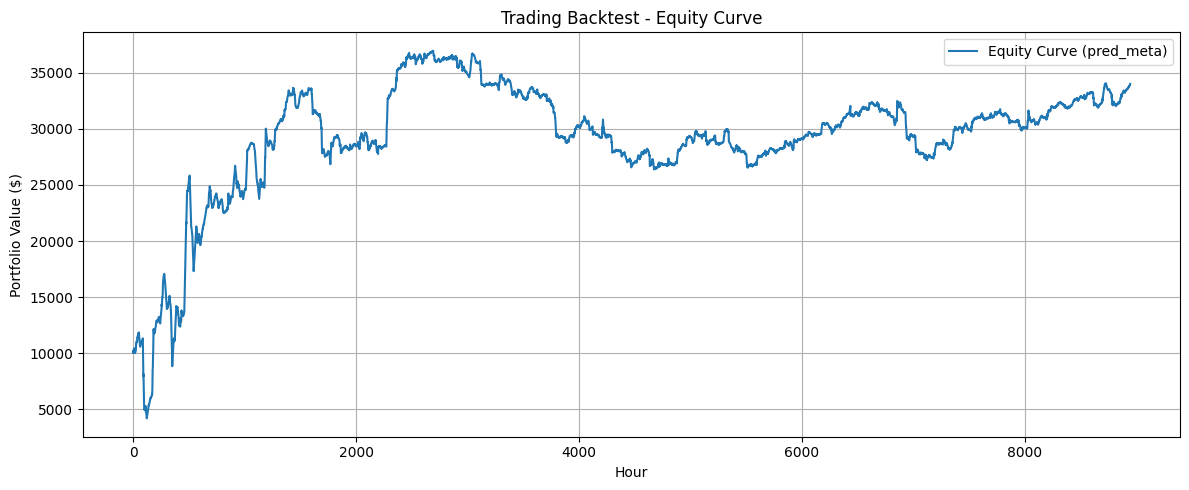

In [34]:
import numpy as np
import matplotlib.pyplot as plt

START_CAPITAL = 10000
model_col = 'pred_meta'  # or 'pred_cnn', etc.

# Make sure to generate predictions for each test sequence and save to bt_df
results = []
for i in range(len(X_test_seq)):
    seq_input = X_test_seq[i].reshape(1, *X_test_seq.shape[1:])  # shape (1, SEQ_LEN, n_features)
    tab_input = X_test[i + SEQ_LEN - 1].reshape(1, -1)           # align tab input with sequence
    y_true = y_test.iloc[i + SEQ_LEN - 1]

    pred_cnn = cnn_model.predict(seq_input, verbose=0)[0][0]
    pred_lstm = lstm_model.predict(seq_input, verbose=0)[0][0]
    pred_xgb = xgb_reg.predict(tab_input)[0]

    meta_X = np.array([[pred_cnn, pred_lstm, pred_xgb,
                        np.mean([pred_cnn, pred_lstm, pred_xgb]),
                        np.std([pred_cnn, pred_lstm, pred_xgb]),
                        np.max([pred_cnn, pred_lstm, pred_xgb]),
                        np.min([pred_cnn, pred_lstm, pred_xgb])]])
    pred_meta = final_model.predict(meta_X)[0]

    results.append({
        'y_true': y_true,
        'pred_cnn': pred_cnn,
        'pred_lstm': pred_lstm,
        'pred_xgb': pred_xgb,
        'pred_meta': pred_meta
    })

bt_df = pd.DataFrame(results)

# Trading simulation as before
capital = START_CAPITAL
pnl = []
positions = []
for idx, row in bt_df.iterrows():
    pred = row[model_col]
    realized = row['y_true']
    # LONG if pred>0, SHORT if pred<0
    if pred > 0:
        pos = 1
    elif pred < 0:
        pos = -1
    else:
        pos = 0
    positions.append(pos)
    pnl.append(pos * realized * capital)

equity_curve = np.cumsum(pnl) + START_CAPITAL
final_capital = equity_curve[-1]
total_pnl = final_capital - START_CAPITAL
total_return_pct = (final_capital / START_CAPITAL - 1) * 100
n_trades = np.count_nonzero(np.array(positions))

print(f"Backtest summary using '{model_col}':")
print(f"Start capital:    ${START_CAPITAL:,.2f}")
print(f"Final capital:    ${final_capital:,.2f}")
print(f"Total PnL:        ${total_pnl:,.2f} ({total_return_pct:.2f}%)")
print(f"Total trades:     {n_trades} (out of {len(bt_df)} hours)")
print(f"Avg hourly PnL:   ${np.mean(pnl):.4f} ± ${np.std(pnl):.4f}")

plt.figure(figsize=(12,5))
plt.plot(equity_curve, label=f'Equity Curve ({model_col})')
plt.title('Trading Backtest - Equity Curve')
plt.xlabel('Hour')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()